In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## modify this graph layout later!
#matplotlib setting defaults
sns.set_theme(style="dark", palette="pastel")
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def missing_data(input_data):
    ''' This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    '''

    total = input_data.isnull().sum() 
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis= 1, keys= ['Total', 'Percent'])
    types = []

    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table['Types'] = types
    return(pd.DataFrame(table))

In [3]:
def mape(actual, pred):
    '''
    MAPE: mean absolute percentage error function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [4]:
df = pd.read_csv('sales_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [5]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [6]:
# aggregrate dataset to categories (family in this case) only
agg_df = df.groupby(['date','family']).agg({'sales': 'sum'}).reset_index().sort_values(['family','date'])

In [7]:
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [8]:
total_sales_df = agg_df.pivot(index='date', columns='family', values='sales')

In [9]:
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                                          
2013-01-01             2.00      5.00            105.00       0.00   110.80   
2013-01-02           121.00    469.00           2411.00       0.00 20871.46   
2013-01-03            83.00    366.00           2476.00       0.00 16597.40   
2013-01-04           127.00    382.00           4796.00       0.00 21625.96   
2013-01-05           180.00    458.00           6715.00       0.00 20879.09   

family      PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  \
date                                                                        
2013-01-01          25.00          0.00                     0.00    42.64   
2013-01-02       17204.00          0.00                     0.00 13975.88   
2013-01-03       12568.00          0.00                     0.00 10674.39   
2013-01-04       11303.00          0.00                     0.00 10772.52   
2013-01-05       16819.00          0.00                     0.00 13475.01   

family      PREPARED FOODS  PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                                      
2013-01-01           37.85     0.00                        0.00     0.00  
2013-01-02         5338.11     0.00                        0.00  1526.75  
2013-01-03         3591.39     0.00                        0.00  1094.31  
2013-01-04         4472.97     0.00                        0.00  1293.12  
2013-01-05         5830.07     0.00                        0.00  1245.64

In [10]:
total_sales_df.drop('LIQUOR,WINE,BEER', axis='columns',inplace=True)
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

In [11]:
%matplotlib inline

First plot all categories sales to see whether there is outlier or not.

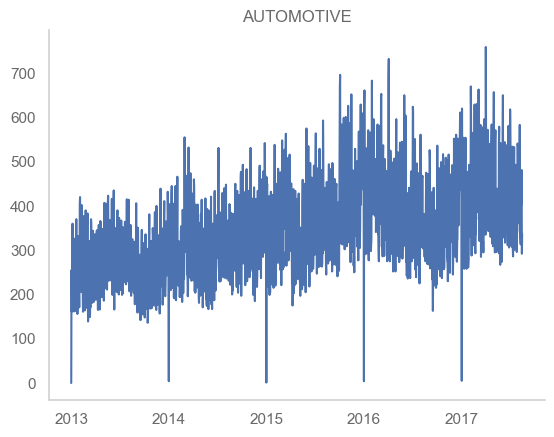

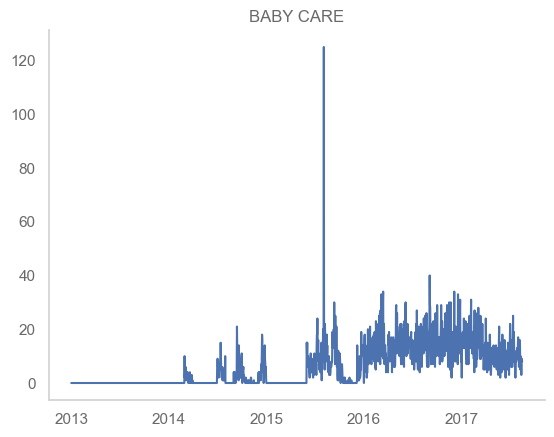

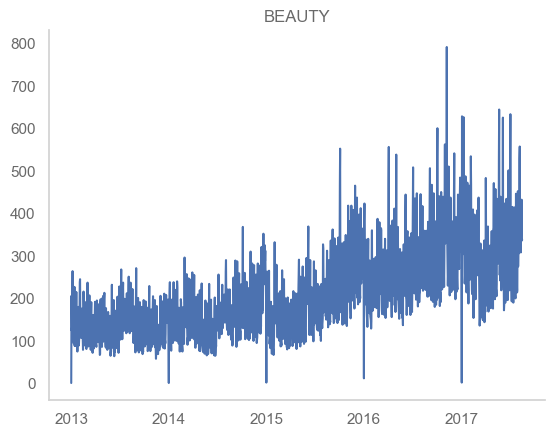

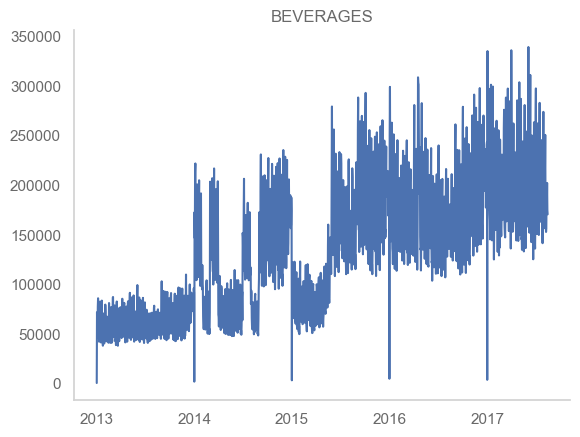

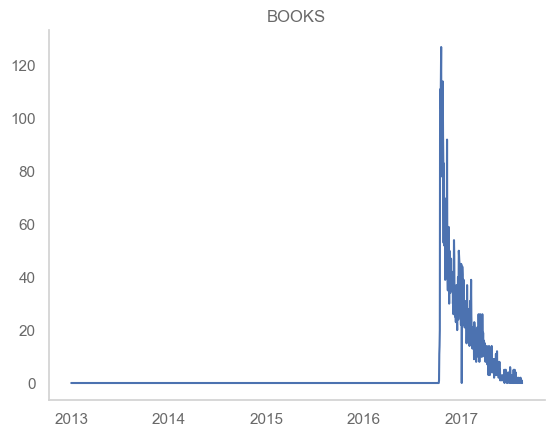

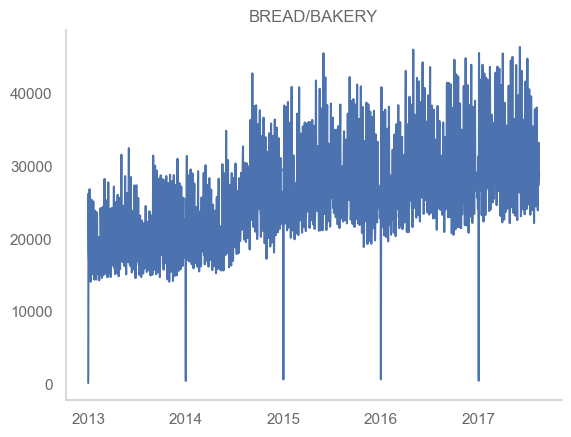

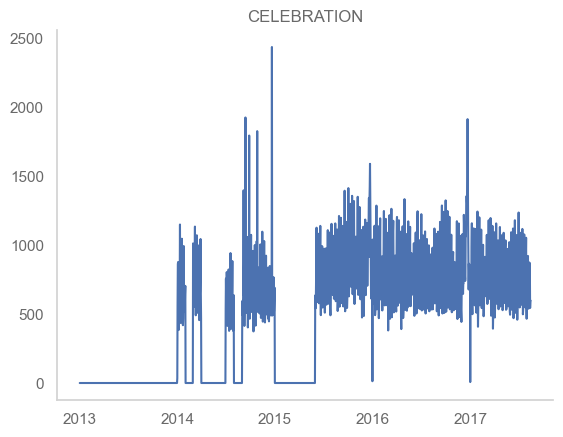

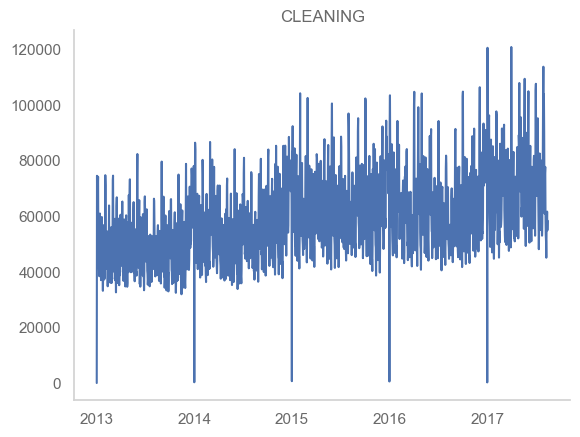

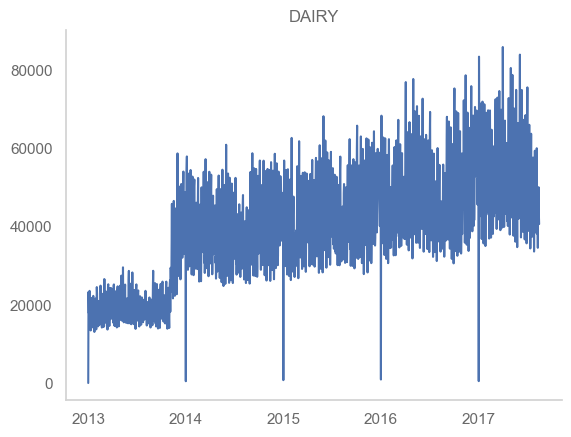

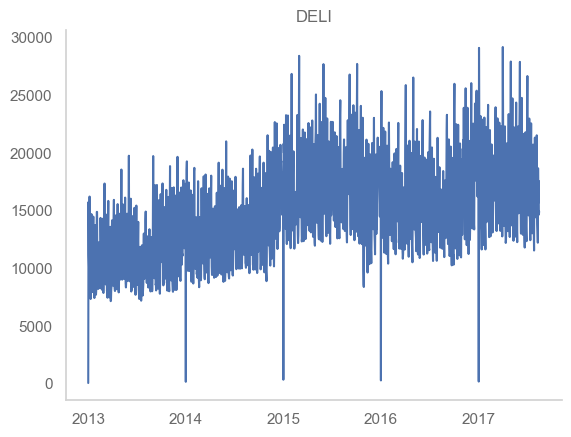

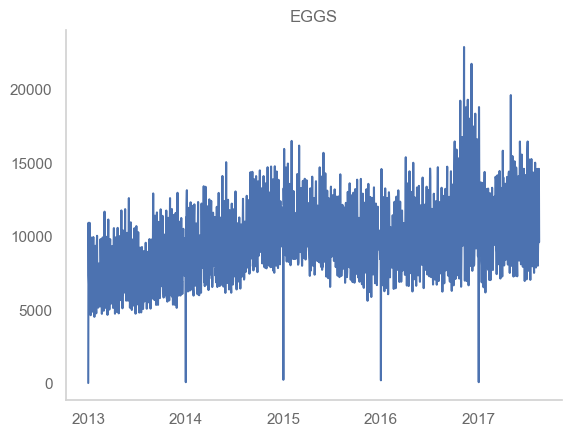

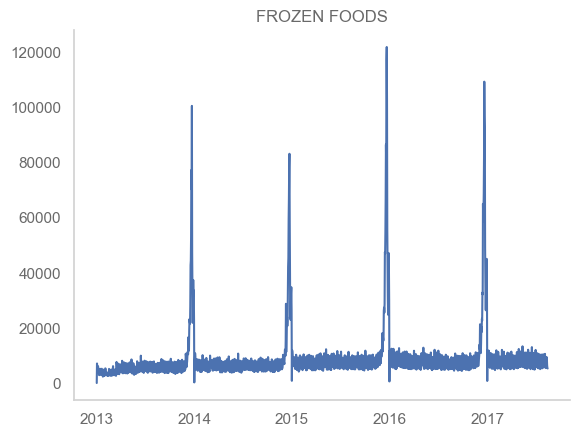

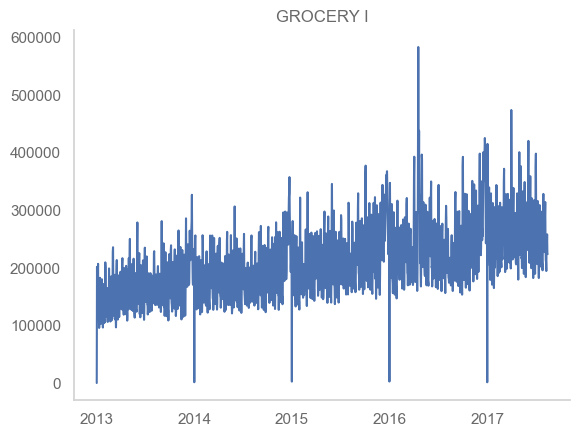

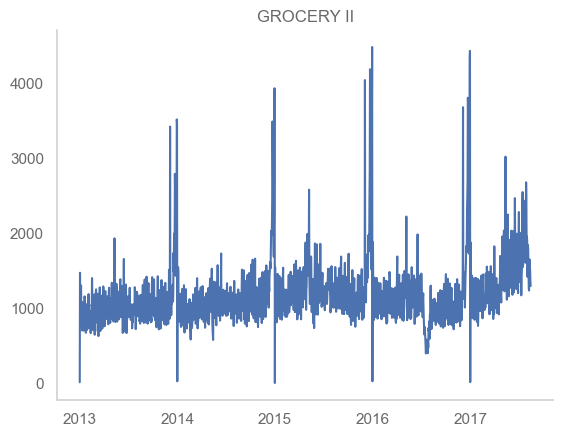

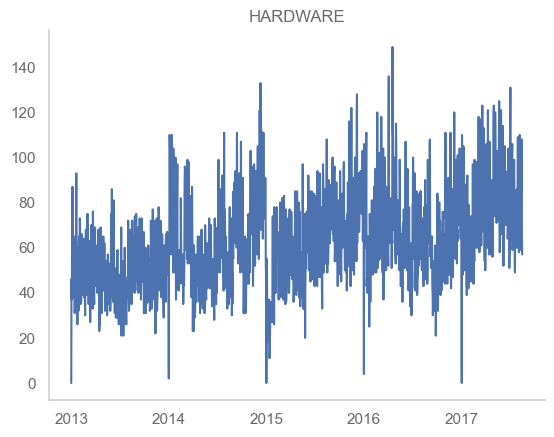

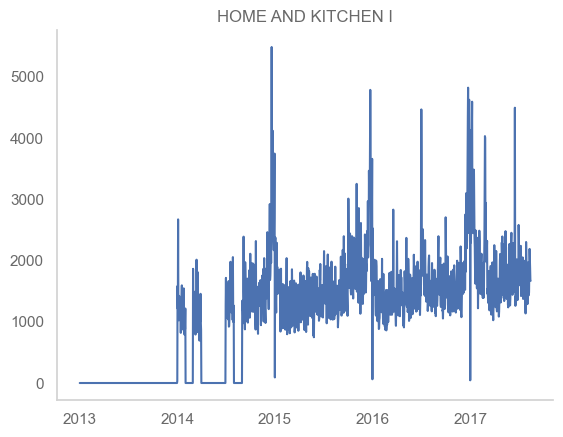

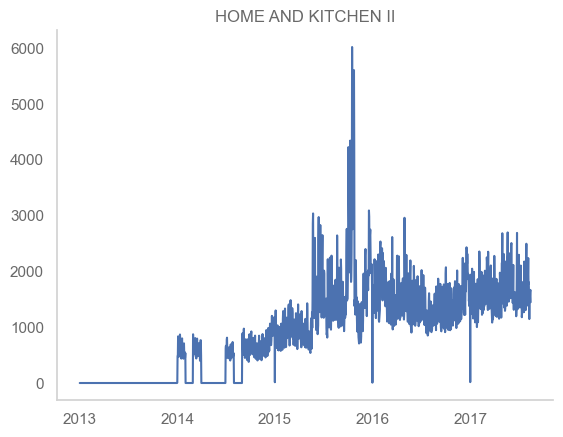

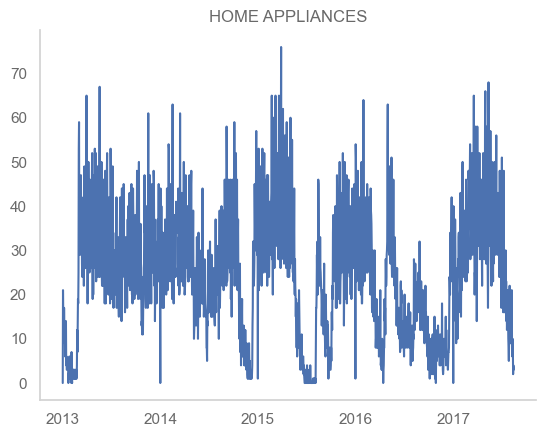

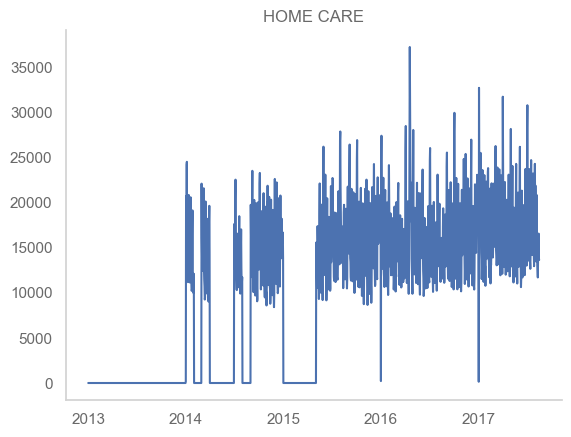

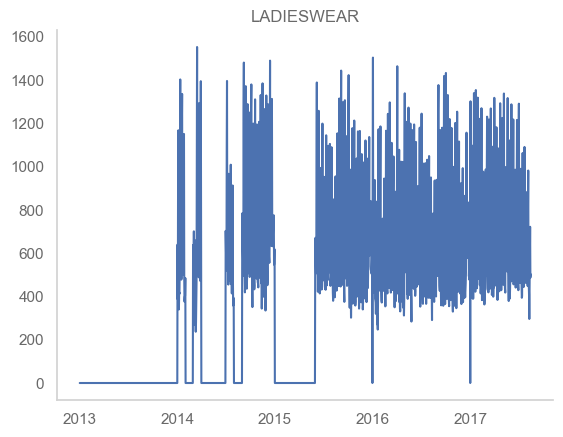

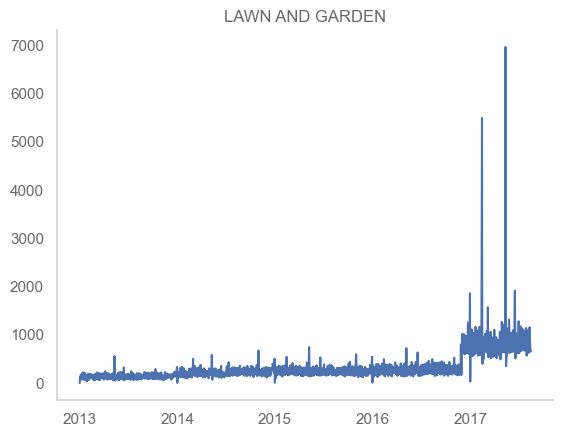

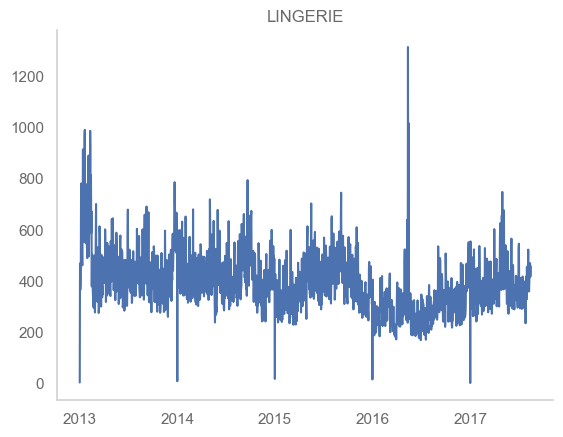

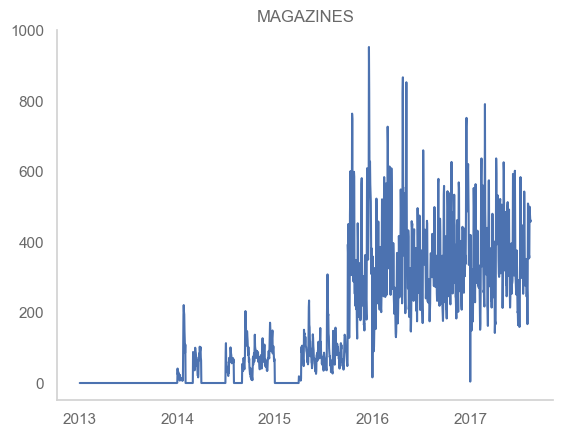

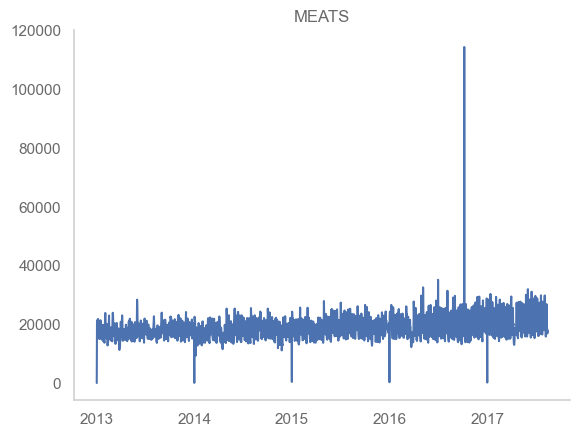

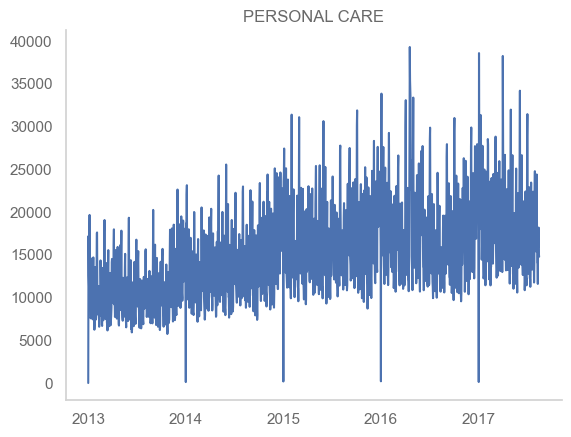

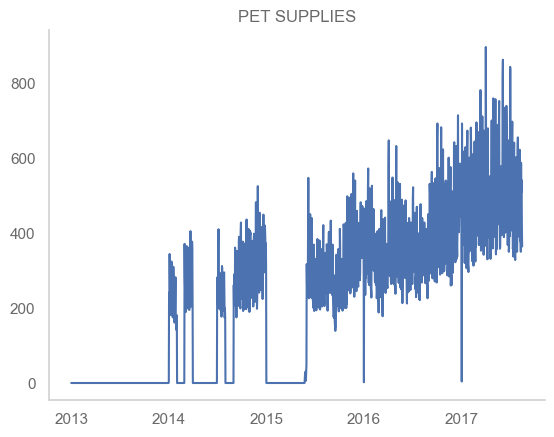

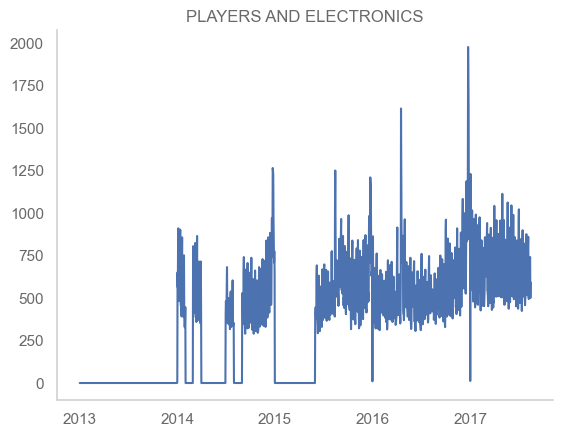

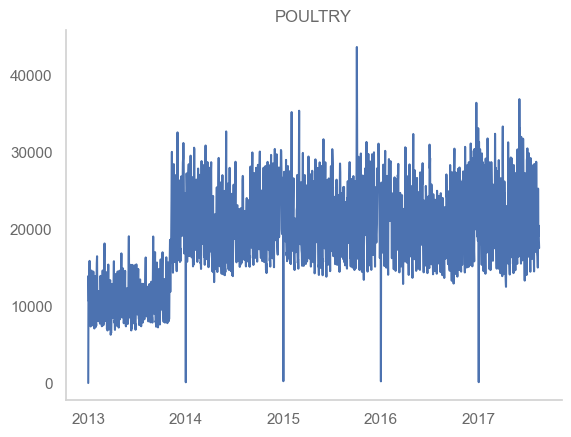

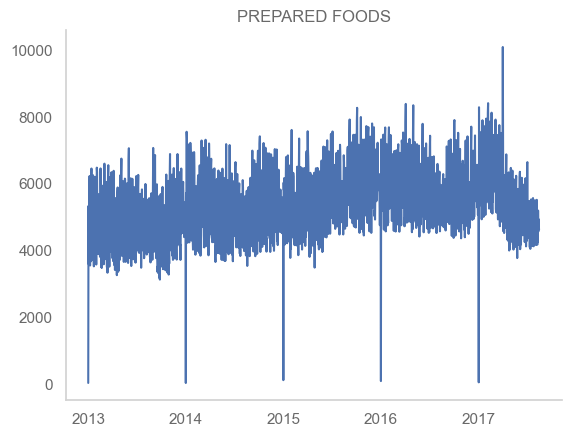

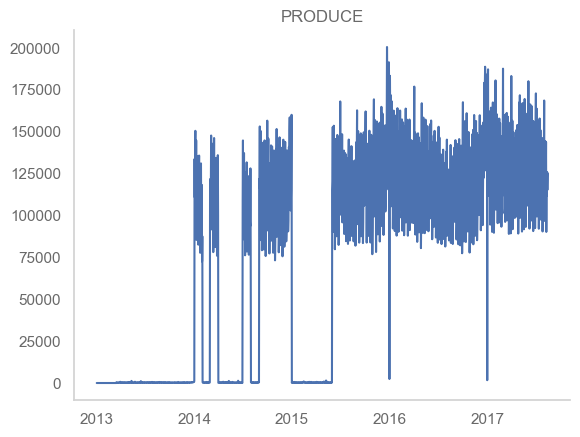

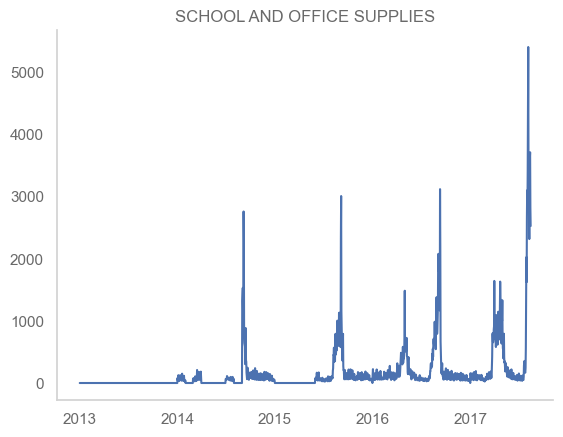

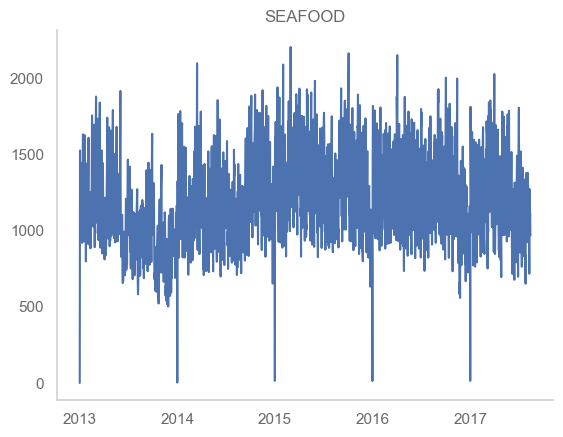

In [12]:
for col in total_sales_df.columns:
    plt.plot(total_sales_df[col])
    plt.title(col)
    plt.show()

There are some odd data points in HOMECARES, LADIESWEAR and PRODUCE, etc. which means this sales data need to clean before fitting model.  

## Data cleaning requirements
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers which heavily bias the model (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

Because in some categories there was no sales from 2013 to 2015 which not good to fit model, only use sales data from 2015-08-15.

In [13]:
total_sales_df = total_sales_df[total_sales_df.index >= '2015-08-15']

In [14]:
#check missing data by missing_data() function
missing_data(total_sales_df).head()

Total  Percent    Types
family                             
AUTOMOTIVE      0     0.00  float64
BABY CARE       0     0.00  float64
BEAUTY          0     0.00  float64
BEVERAGES       0     0.00  float64
BOOKS           0     0.00  float64

##### 1. Remove low-volume data (in this case is avg daily sales < 1000)

In [15]:
old_len = len(total_sales_df.columns)

#keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


##### 2. Remove 0 value in daily sales

In [16]:
#get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

After checking for 0 values, we can keep all categories we have left in the df.

In [17]:
print(total_sales_df.columns)

Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HOME AND KITCHEN I',
       'HOME AND KITCHEN II', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SEAFOOD'],
      dtype='object', name='family')


##### 3. Remove outliers by z-score method

In [18]:
prediction_df_list = []

#using z-score to remove outliers
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()

    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0]
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)

    df_clean.drop(index=outlier_index, inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)


Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


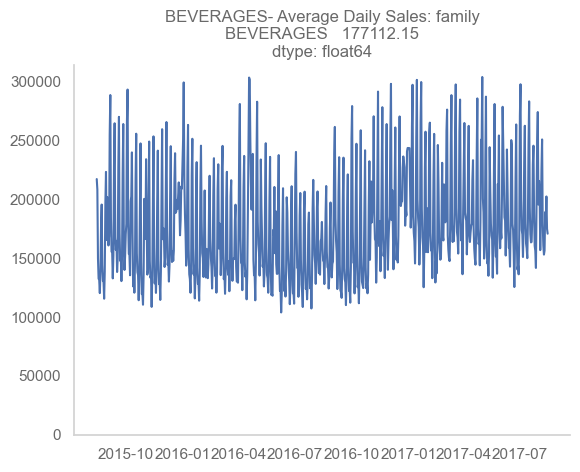

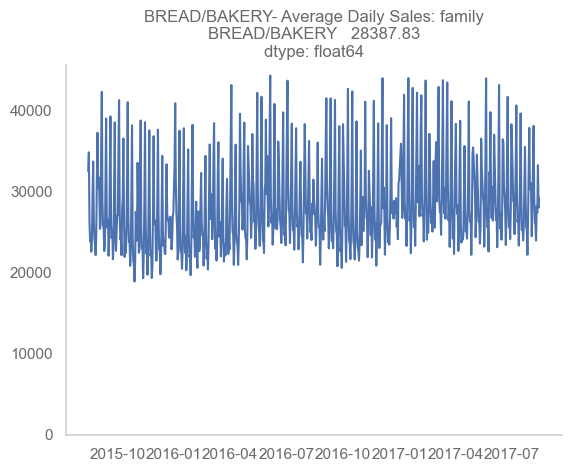

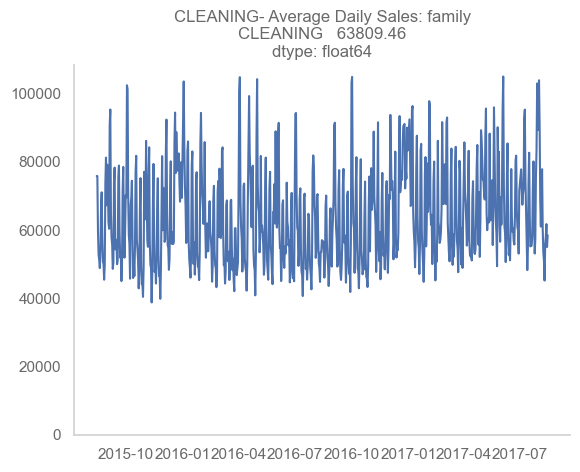

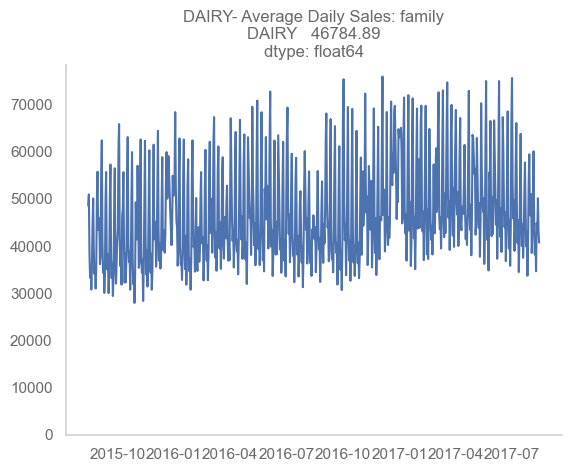

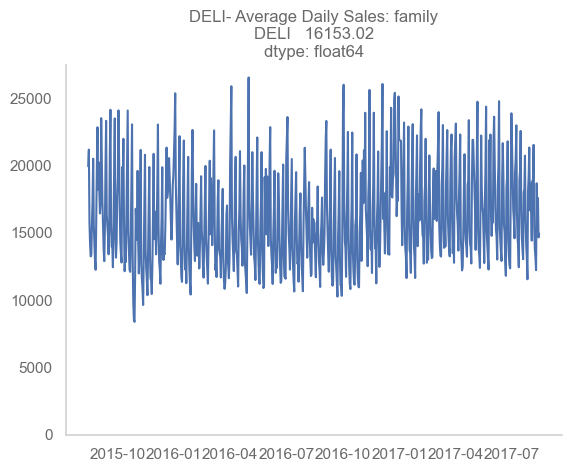

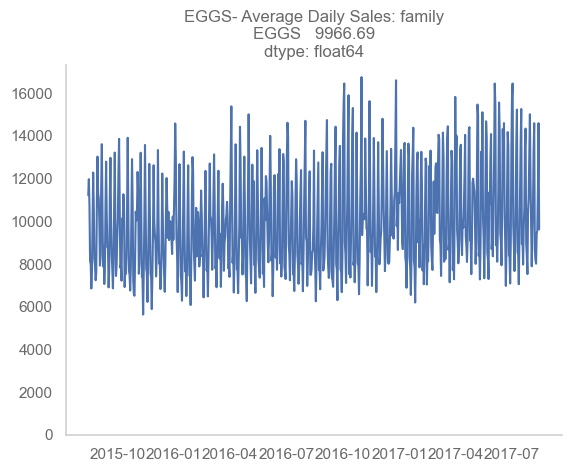

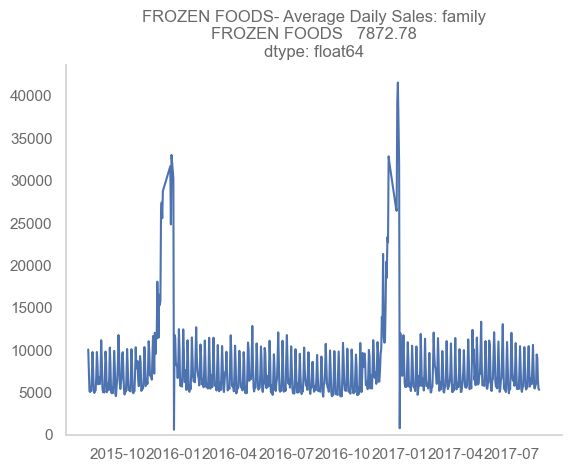

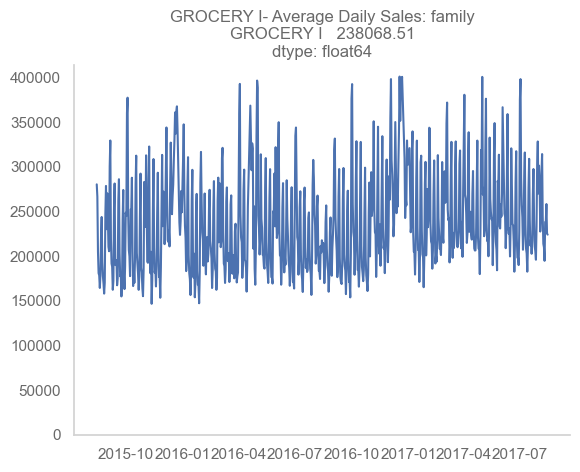

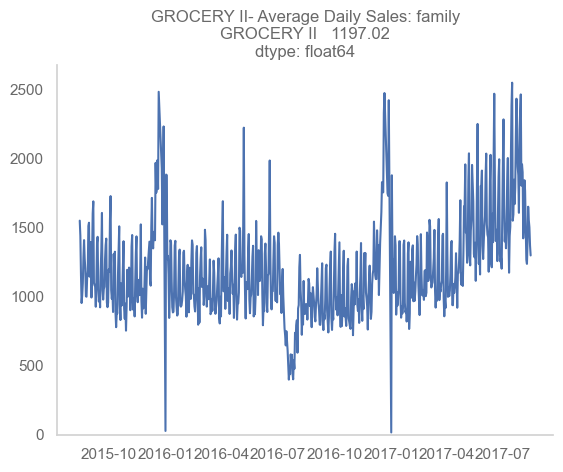

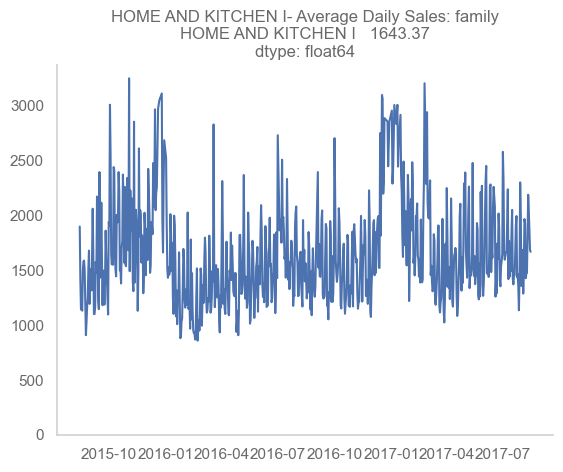

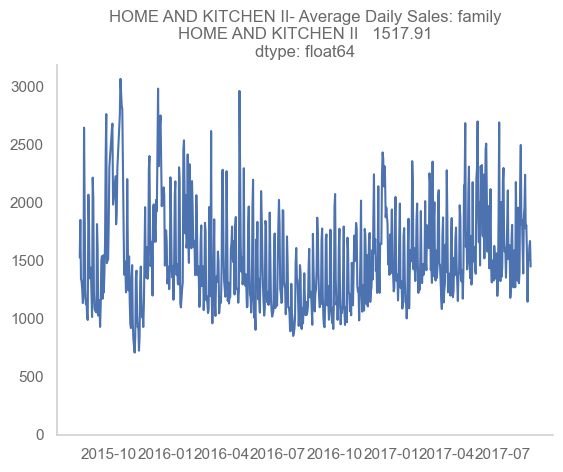

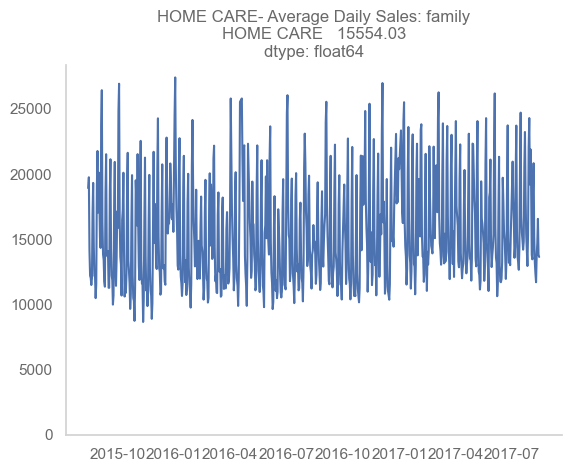

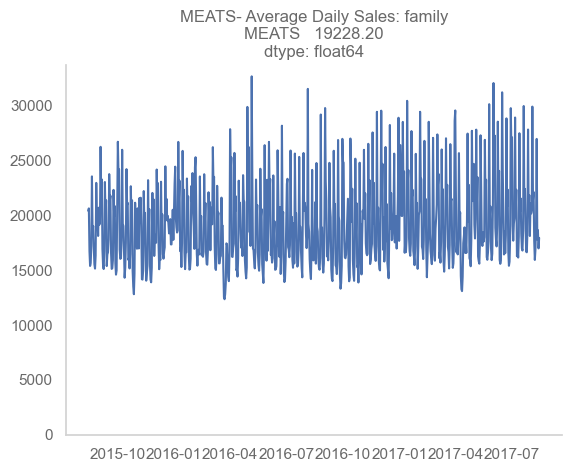

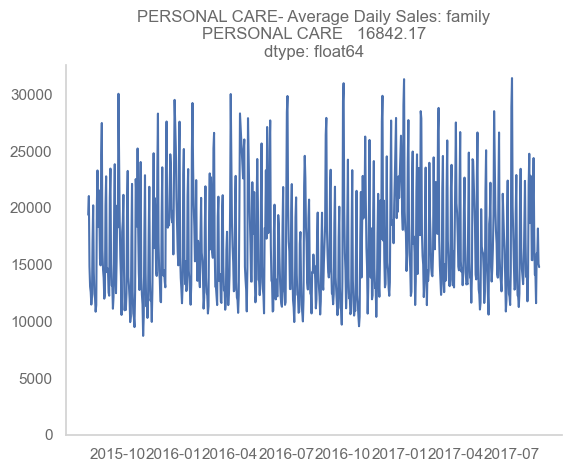

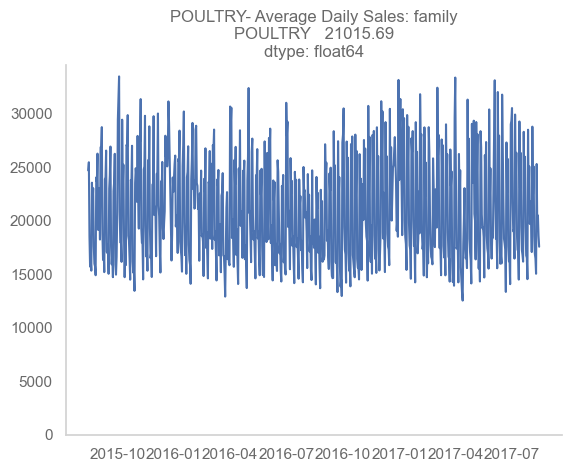

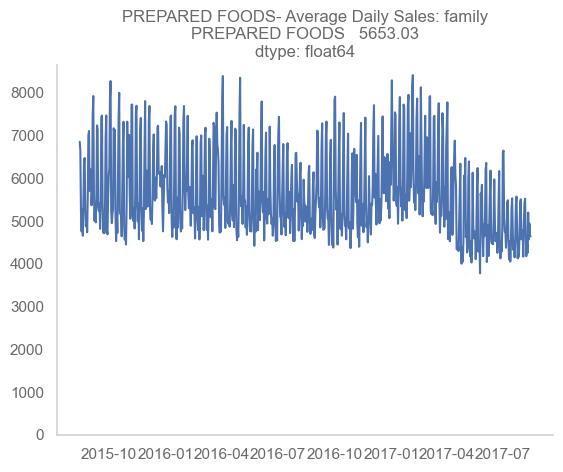

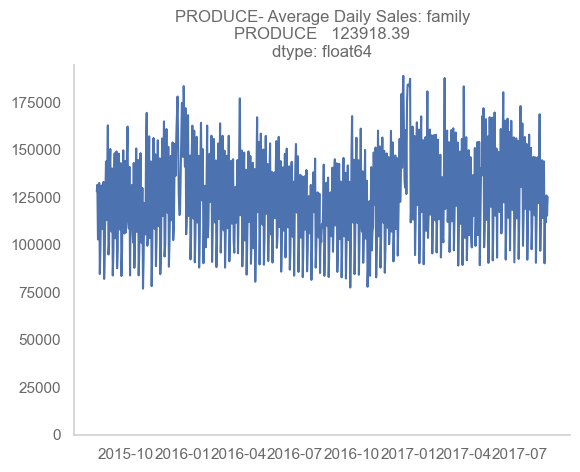

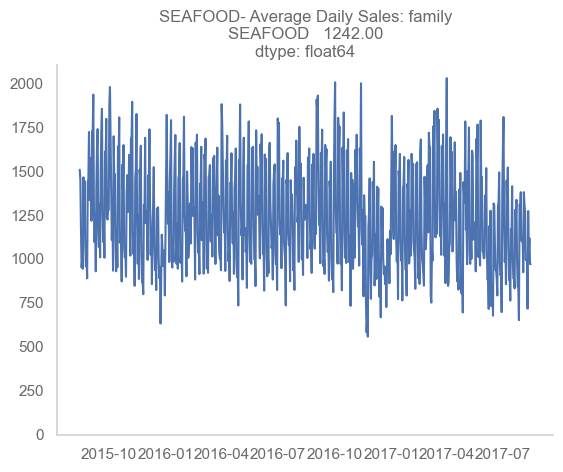

In [19]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## PLOTTING CATEGORIES
Break sales volume of each categories into 3 groups: low, mid, high based on percentile respectively 33, 66 and 100 
(0 to 33%, 33% to 66%, 66% to 100%) in order to compare and forecast in the same scale.


In [20]:
avg_daily_sales = total_sales_df.apply(np.mean, axis = 0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis =0).sort_values(),[33,66])

In [21]:
low_vol_cate = avg_daily_sales[avg_daily_sales <= low].index
mid_vol_cate = avg_daily_sales[(avg_daily_sales > low) & (avg_daily_sales < mid)].index
high_vol_cate = avg_daily_sales[avg_daily_sales >= mid].index

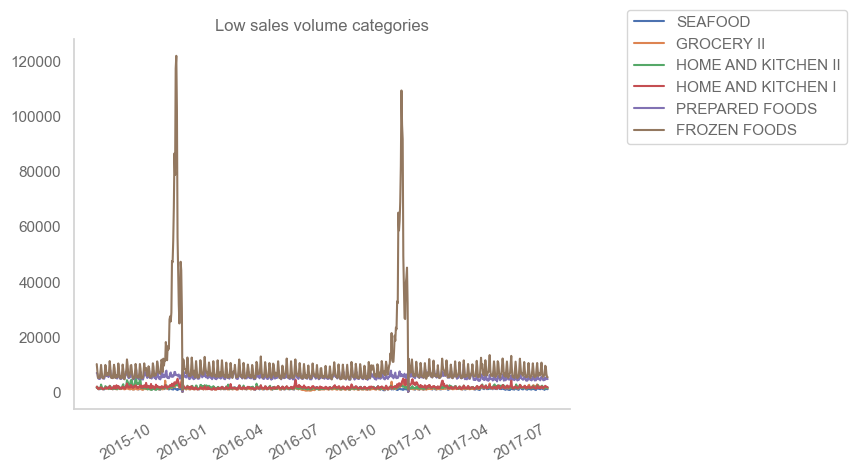

In [22]:
plt.title('Low sales volume categories')
plt.plot(total_sales_df[low_vol_cate])
plt.legend(low_vol_cate,loc='best', bbox_to_anchor =(1.1, 1.1))
plt.xticks(rotation = 30)
plt.show()

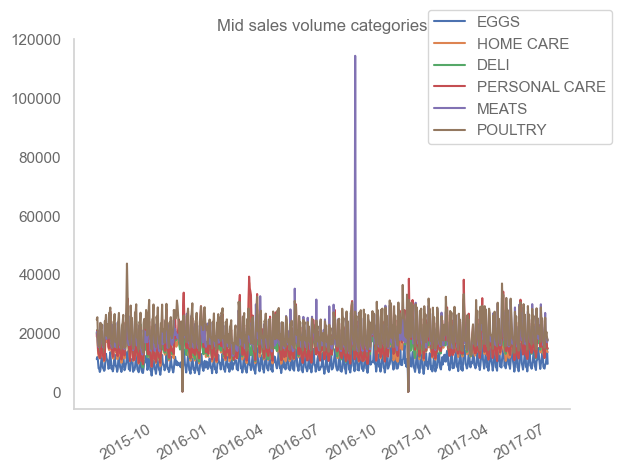

In [23]:
plt.title('Mid sales volume categories')
plt.plot(total_sales_df[mid_vol_cate])
plt.legend(mid_vol_cate,loc='best', bbox_to_anchor =(1.1, 1.1))
plt.xticks(rotation = 30)
plt.show()

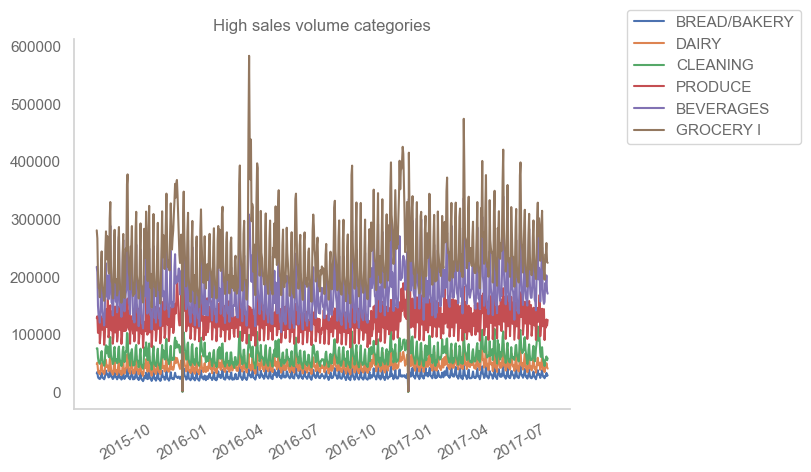

In [24]:
plt.title('High sales volume categories')
plt.plot(total_sales_df[high_vol_cate])
plt.legend(high_vol_cate,loc='best', bbox_to_anchor =(1.1, 1.1))
plt.xticks(rotation = 30)
plt.show()

## Test model with a high volume metric (PRODUCE) first. 

In [25]:
#set var
feature = 'PRODUCE'
prediction_days = 30

In [26]:
#create PRODUCE dataframe
df = total_sales_df[[feature]].reset_index()
df.head()

family       date   PRODUCE
0      2015-08-15 128147.18
1      2015-08-16 131493.93
2      2015-08-17 102769.60
3      2015-08-18 106468.23
4      2015-08-19 132449.58

##### HOLIDAY DATA
Benefit of holiday parameter
1. Trend of data
2. Impact of holiday
3. Impact of seasonality

In [27]:
import holidays
from datetime import datetime, timedelta, date 

In [28]:
#add holiday data
holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC() #this is a dict
ecuador_holidays = holidays.country_holidays('EC') #this is a dict, takes a string

In [29]:
# get all holidays out and add window of holidays as total 4 days around a holiday date (before holiday 2 days and after holiday 1 day) because it could induce seasonality

for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

https://pypi.org/project/holidays/

##### BACKTESTING ON TRAIN TEST SPLIT DATA TO SEE THIS MODEL MAPE SO FAR
MAPE: how accurate this model

In [30]:
# test split on 1 month data start from 2017-07-01 to 2017-08-01
forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_dt = (forecast_start_dt).strftime("%Y-%m-%d") #Prophet timestamp required format
print(forecast_start_dt)

2017-07-01


In [31]:
# PROPHET MODEL
df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})

# set up feature
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
# set up target
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

#train split
train_set = df_copy[(df_copy['ds'] < forecast_start_dt)] # train model up to forecast_start_dt

m = Prophet() #will add parameter in this step later on
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>= forecast_start_dt 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
predicted_df.head(10)

ds      yhat
684 2017-07-01 144612.13
685 2017-07-02 155336.04
686 2017-07-03 122383.38
687 2017-07-04 127642.39
688 2017-07-05 160253.27
689 2017-07-06 102667.68
690 2017-07-07 116017.82
691 2017-07-08 144864.32
692 2017-07-09 155588.23
693 2017-07-10 122635.58

In [33]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [34]:
predicted_df

ds      yhat     ytrue
0  2017-07-01 144612.13 155487.63
1  2017-07-02 155336.04 172890.14
2  2017-07-03 122383.38 130389.20
3  2017-07-04 127642.39 131534.55
4  2017-07-05 160253.27 163804.33
5  2017-07-06 102667.68  99395.60
6  2017-07-07 116017.82 114346.57
7  2017-07-08 144864.32 139294.77
8  2017-07-09 155588.23 156633.92
9  2017-07-10 122635.58 118856.99
10 2017-07-11 127894.58 122176.36
11 2017-07-12 160505.46 152978.41
12 2017-07-13 102919.87  92111.27
13 2017-07-14 116270.01 110263.08
14 2017-07-15 145116.52 133166.71
15 2017-07-16 155840.43 157883.06
16 2017-07-17 122887.77 119026.44
17 2017-07-18 128146.78 118281.40
18 2017-07-19 160757.66 150952.70
19 2017-07-20 103172.07  97593.17
20 2017-07-21 116522.21 110555.13
21 2017-07-22 145368.71 130700.68
22 2017-07-23 156092.62 146226.46
23 2017-07-24 123139.97 117117.10
24 2017-07-25 128398.97 115457.66
25 2017-07-26 161009.85 145917.92
26 2017-07-27 103424.26  90481.29
27 2017-07-28 116774.40 111948.89
28 2017-07-29 145620.91 131988.66
29 2017-07-30 156344.81 146045.80

In [35]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

6.2638811231541665

##### Cross validation with Prophet
Find best param by testing over periods of time with those param

In [36]:
m = Prophet()
m.fit(train_set)
df_cv_test = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1]

In [37]:
df_p_test = performance_metrics(df_cv_test)
df_p_test.head()

horizon          mse     rmse      mae  mape  mdape  smape  coverage
0  3 days 411911254.07 20295.60 13088.62  0.09   0.07   0.10      0.80
1  4 days 269732789.34 16423.54 11119.74  0.08   0.06   0.08      0.80
2  5 days 141547986.52 11897.39  8894.95  0.07   0.06   0.07      0.87
3  6 days 126310847.91 11238.81  9216.62  0.07   0.07   0.07      0.87
4  7 days  95815198.40  9788.52  8407.64  0.07   0.07   0.07      0.93

In [38]:
df_p_test.tail()

horizon           mse     rmse      mae  mape  mdape  smape  coverage
23 26 days  254632370.78 15957.20 12018.61  0.10   0.08   0.10      0.80
24 27 days  305198598.48 17469.93 13245.62  0.11   0.09   0.11      0.77
25 28 days  502076648.26 22407.07 15686.99  0.13   0.08   0.13      0.73
26 29 days  549411933.51 23439.54 16593.94  0.12   0.09   0.13      0.66
27 30 days 1247042864.57 35313.49 21490.91  3.01   0.12   0.19      0.63

##### Hypertune model
Optimize for "PRODUCE" feature to get lower mape

In [ ]:
param_grid_test = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

#generate all combinations of param
all_params_test = [dict(zip(param_grid_test.keys(), v)) for v in itertools.product(*param_grid_test.values())]
rmses = []

#cross validation to evaluate all param
for params in all_params_test:
    m = Prophet(**params).fit(train_set)
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results_test = pd.DataFrame(all_params_test)
tuning_results_test['rmses'] = rmses


In [40]:
tuning_results_test.sort_values('rmses')

changepoint_prior_scale  seasonality_prior_scale    rmses
11                     0.10                    10.00 17712.65
10                     0.10                     1.00 17714.22
7                      0.01                    10.00 17722.73
9                      0.10                     0.10 17727.24
13                     0.50                     0.10 17752.96
6                      0.01                     1.00 17756.78
14                     0.50                     1.00 17759.66
15                     0.50                    10.00 17772.76
5                      0.01                     0.10 17779.54
8                      0.10                     0.01 18096.29
12                     0.50                     0.01 18098.10
4                      0.01                     0.01 18185.61
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21

In [41]:
dict(tuning_results_test.sort_values('rmses').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmses': 17712.6503315396}

In [42]:
params_dictionary = dict(tuning_results_test.sort_values('rmses').reset_index(drop=True).drop('rmses',axis='columns').iloc[0])

In [43]:
#fit model again with changepoint_prior_scale & seasonality_prior_scale that has lowest rmse
m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#add only forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

16:36:01 - cmdstanpy - INFO - Chain [1] start processing
16:36:01 - cmdstanpy - INFO - Chain [1] done processing


4.930856525244661

## HYPERPARAMETER TUNING AND BACKTESTING PIPELINE
1. changepoint_prior_scale [0.001, 0.5]
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10]
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [44]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holiday_prior_scale_range = np.linspace(0.01, 10, num =5).tolist()
#output changepoint_prior_scale_range: [0.001, 0.12575, 0.2505, 0.37525, 0.5]
#output seasonality_prior_scale_range: [0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]
#output holiday_prior_scale_range: [0.01, 2.5075, 5.005, 7.5024999999999995, 10.0]

In [ ]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ['ds','y']

    category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
    category_df['ds'] = pd.to_datetime(category_df['ds'])

    param_grid ={
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range 
    }
    
    #generate all combinations of param
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []

    #cross validation to evaluate all param
    for params in all_params:
        m =Prophet(**params).fit(category_df)
        df_cv = cross_validation(m, initial='365 days', period= '30 days', horizon ='30 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p['mape'].values[0])

    #find the best param
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes

    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values('mape').reset_index(drop=True).iloc[0])
    params_dict['column'] = feature

    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))



In [48]:
#call param_dict for a feature
dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2934336030210439,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2860222755654023,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6852172547557758,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.38016552551952454,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.437359490501228,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4661483701900106,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46946927198631955,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_s

##### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [49]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

In [52]:
#Prophet model
forecasted_dfs = []

for feature in total_sales_df.columns:
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']

    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])

    df_copy_= df_copy[df_copy['ds'] < forecast_start_date]

    #finding right param dict for this category
    params_dict = dicts[feature]

    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode= 'multiplicative',
                holidays = holiday                                          
                )
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods= prediction_days)
    fcst_prophet_train = m.predict(future)

    #add only forecasted data into predicted_df
    filter = fcst_prophet_train['ds'] > forecast_start_date
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))



15:10:37 - cmdstanpy - INFO - Chain [1] start processing
15:10:38 - cmdstanpy - INFO - Chain [1] done processing
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:38 - cmdstanpy - INFO - Chain [1] start processing
15:10:38 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:38 - cmdstanpy - INFO - Chain [1] start processing
15:10:38 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:38 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing


CLEANING nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing


DAIRY nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing


DELI nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing


EGGS nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN I nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN II nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing


MEATS nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:42 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:42 - cmdstanpy - INFO - Chain [1] done processing


POULTRY nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:42 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15:10:43 - cmdstanpy - INFO - Chain [1] start processing
15:10:43 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE nan
SEAFOOD nan


/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thaonguyen/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CLEANING, FROZEN FOOD and GROCERY II have high MAPE, need further investigation on sales historical data because maybe model can not predict something about it. 

##### FINAL FORECASTING

In [51]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)

15:32:50 - cmdstanpy - INFO - Chain [1] start processing
15:32:50 - cmdstanpy - INFO - Chain [1] done processing


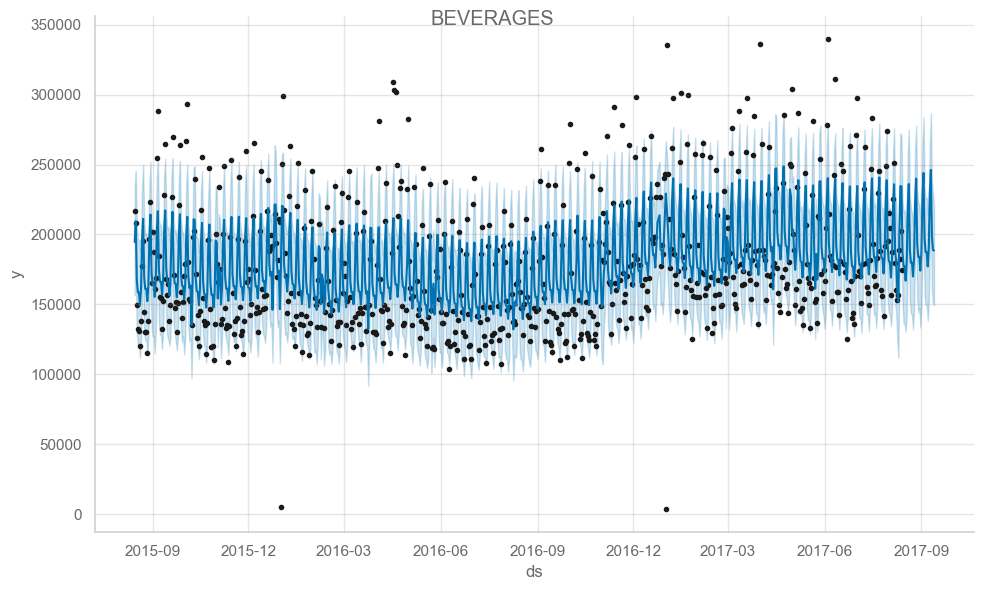

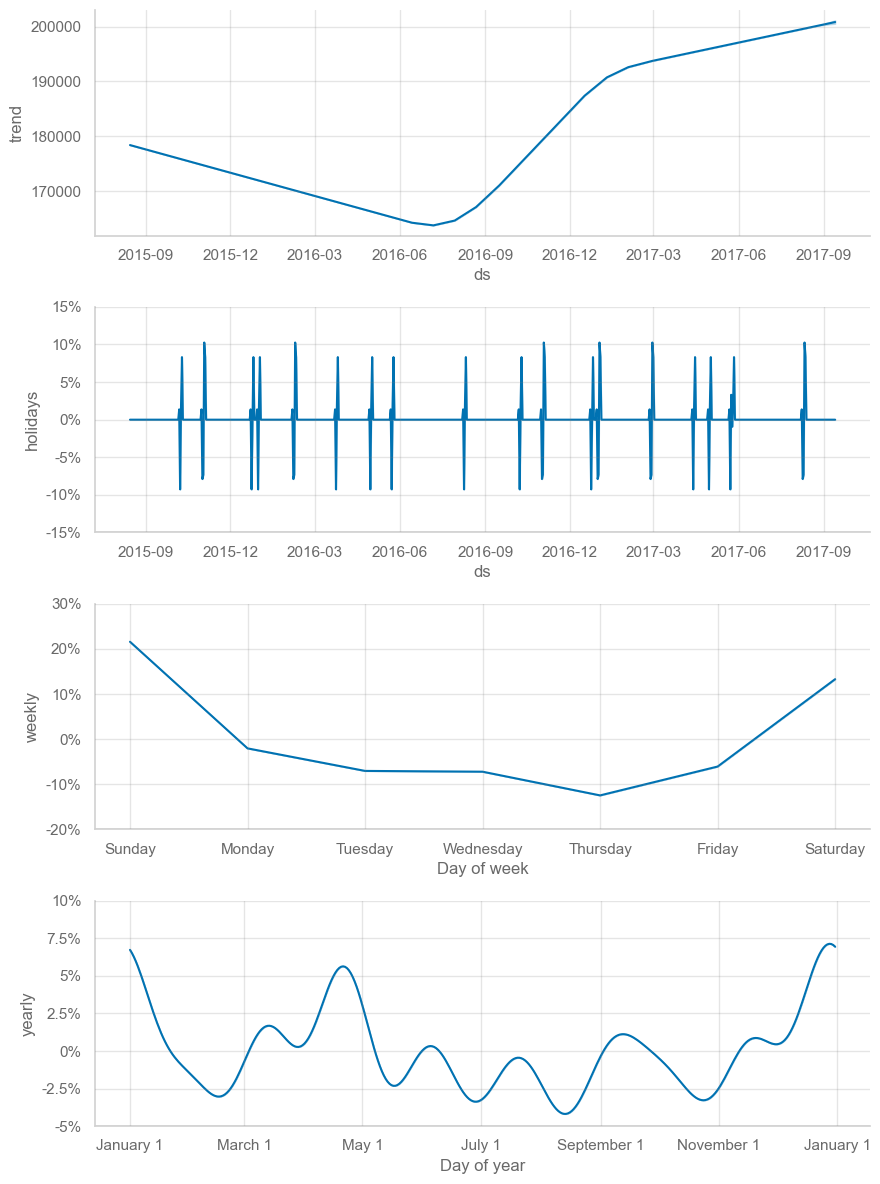

15:32:51 - cmdstanpy - INFO - Chain [1] start processing
15:32:51 - cmdstanpy - INFO - Chain [1] done processing


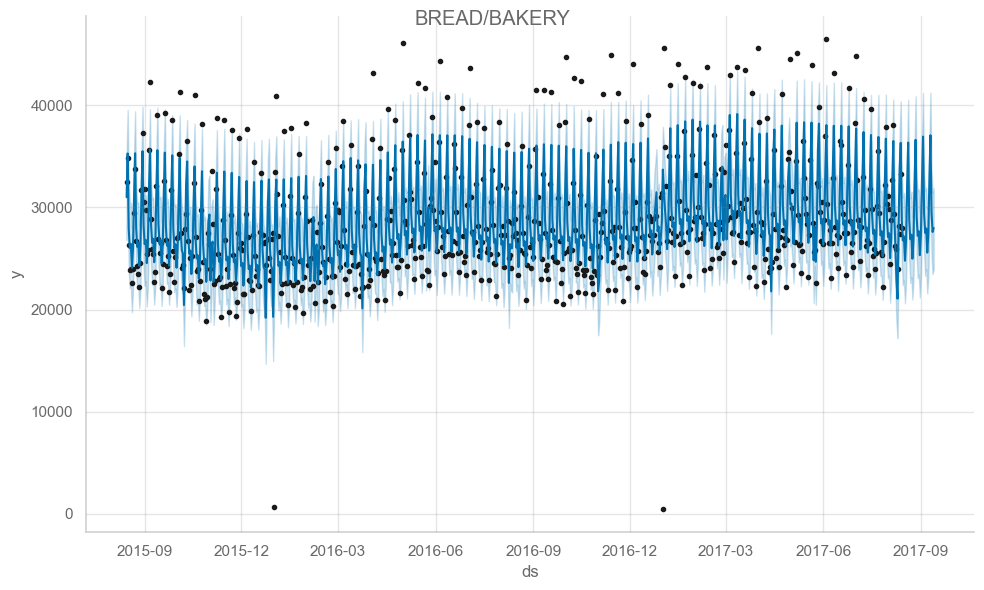

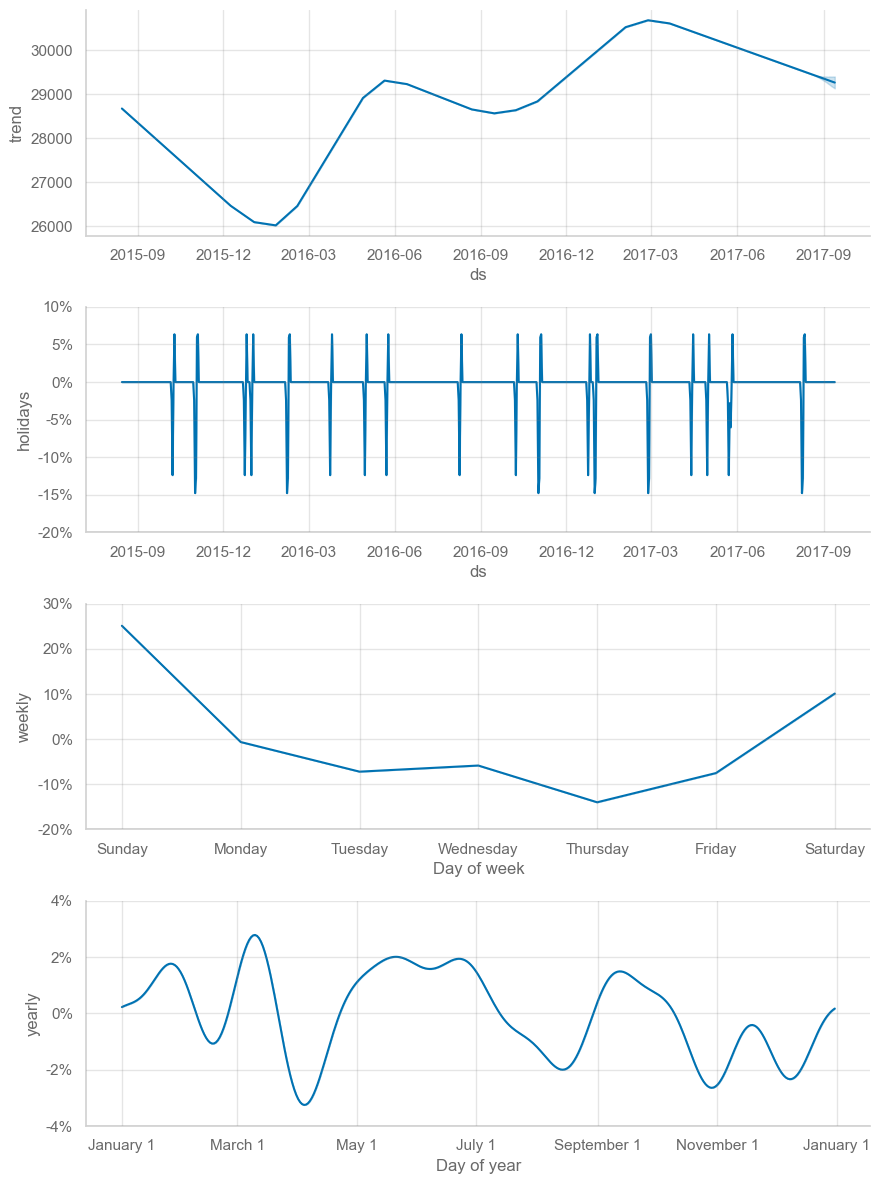

15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:52 - cmdstanpy - INFO - Chain [1] done processing


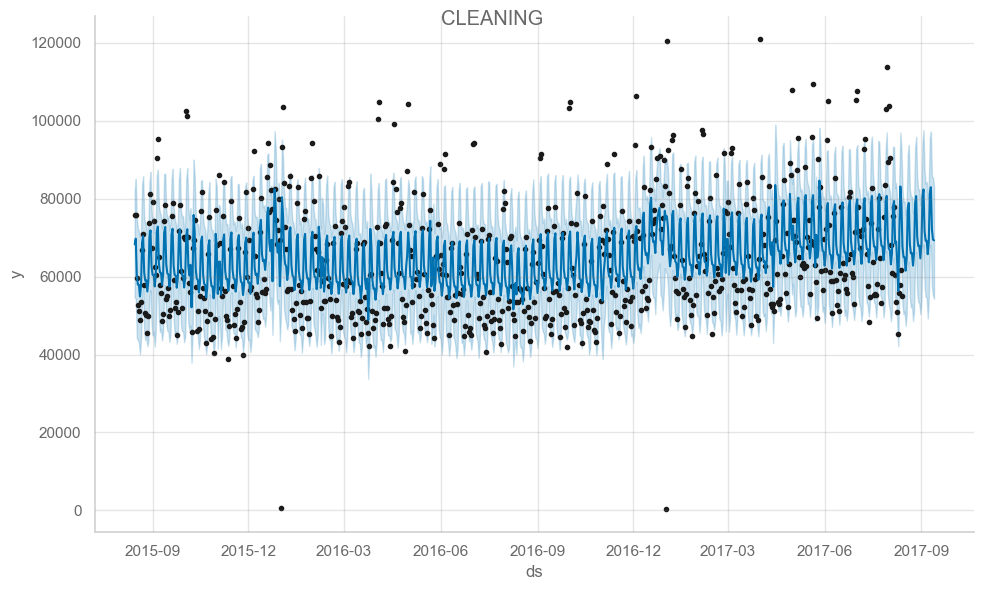

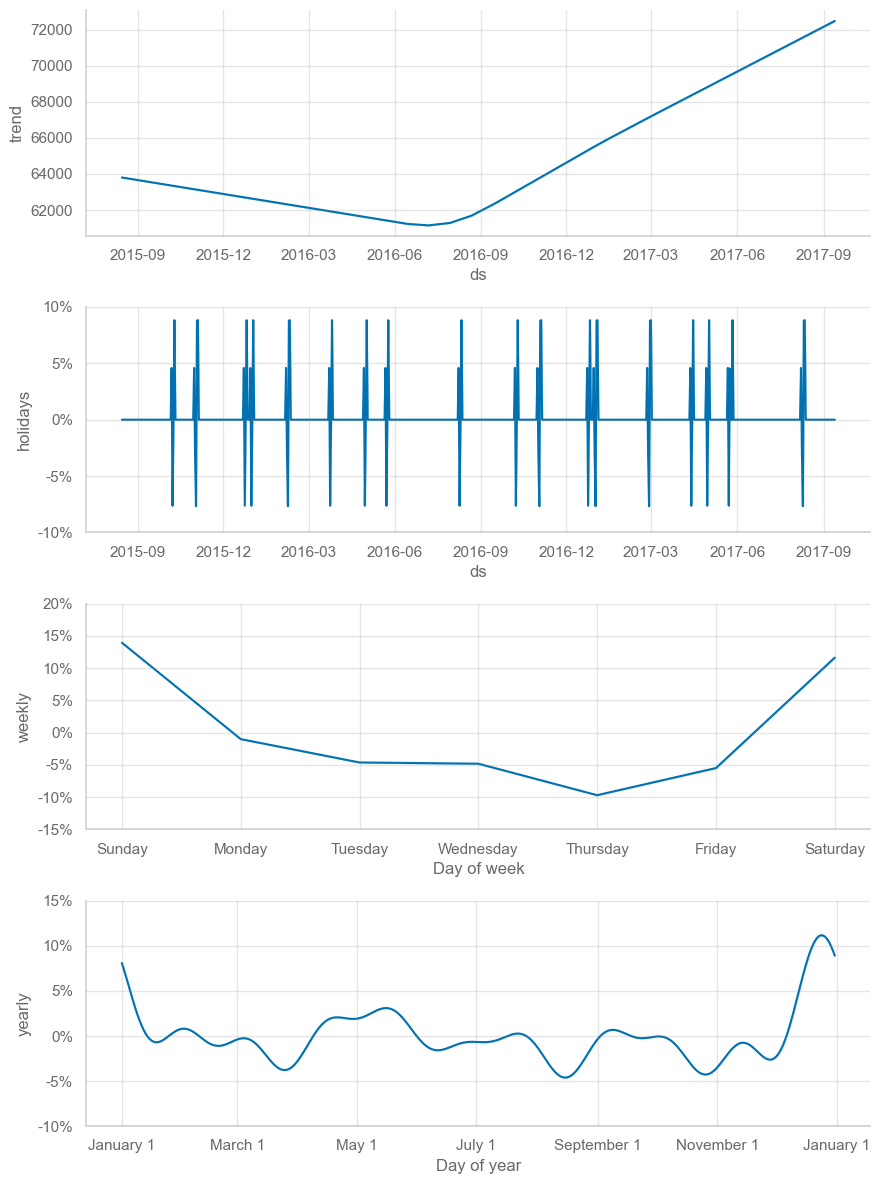

15:32:54 - cmdstanpy - INFO - Chain [1] start processing
15:32:54 - cmdstanpy - INFO - Chain [1] done processing


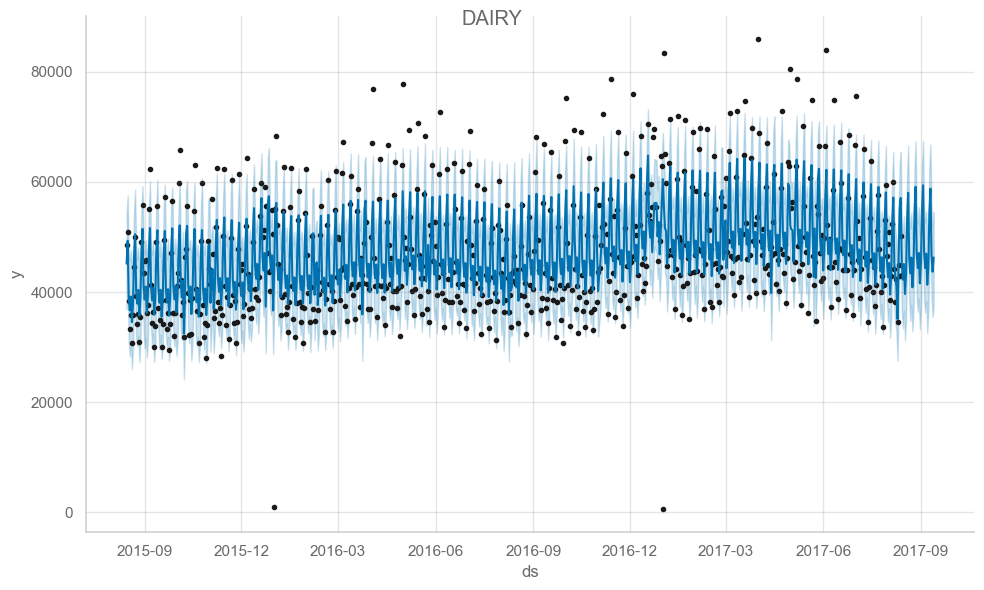

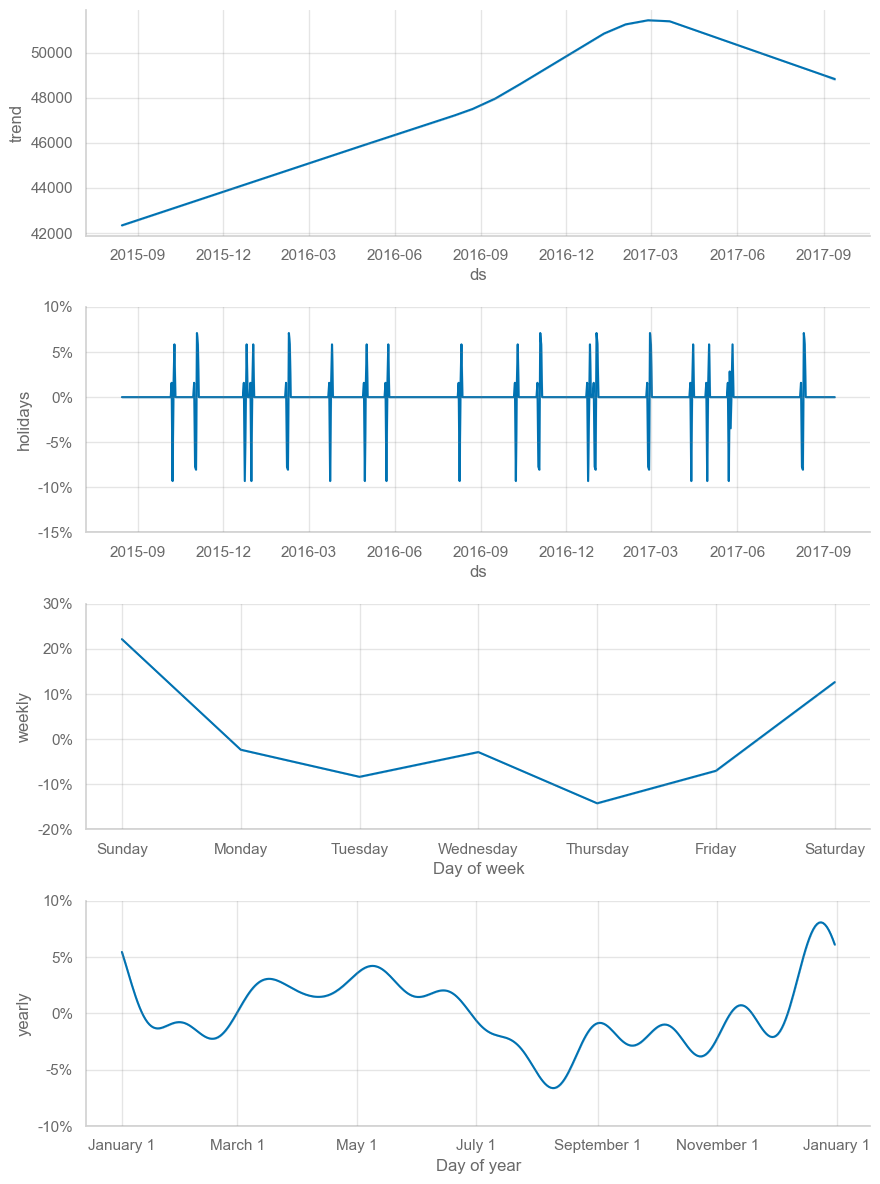

15:32:55 - cmdstanpy - INFO - Chain [1] start processing
15:32:55 - cmdstanpy - INFO - Chain [1] done processing


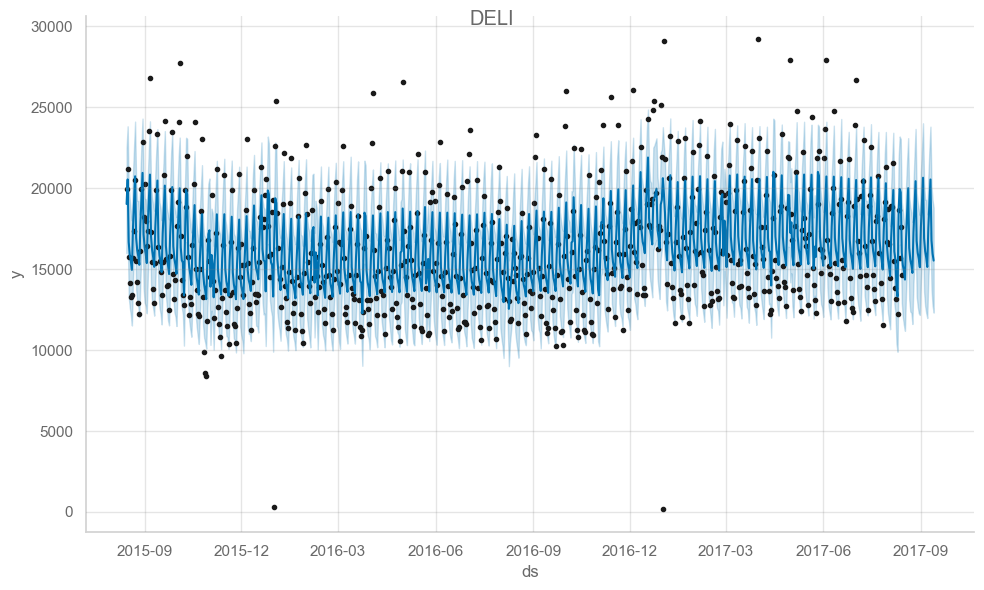

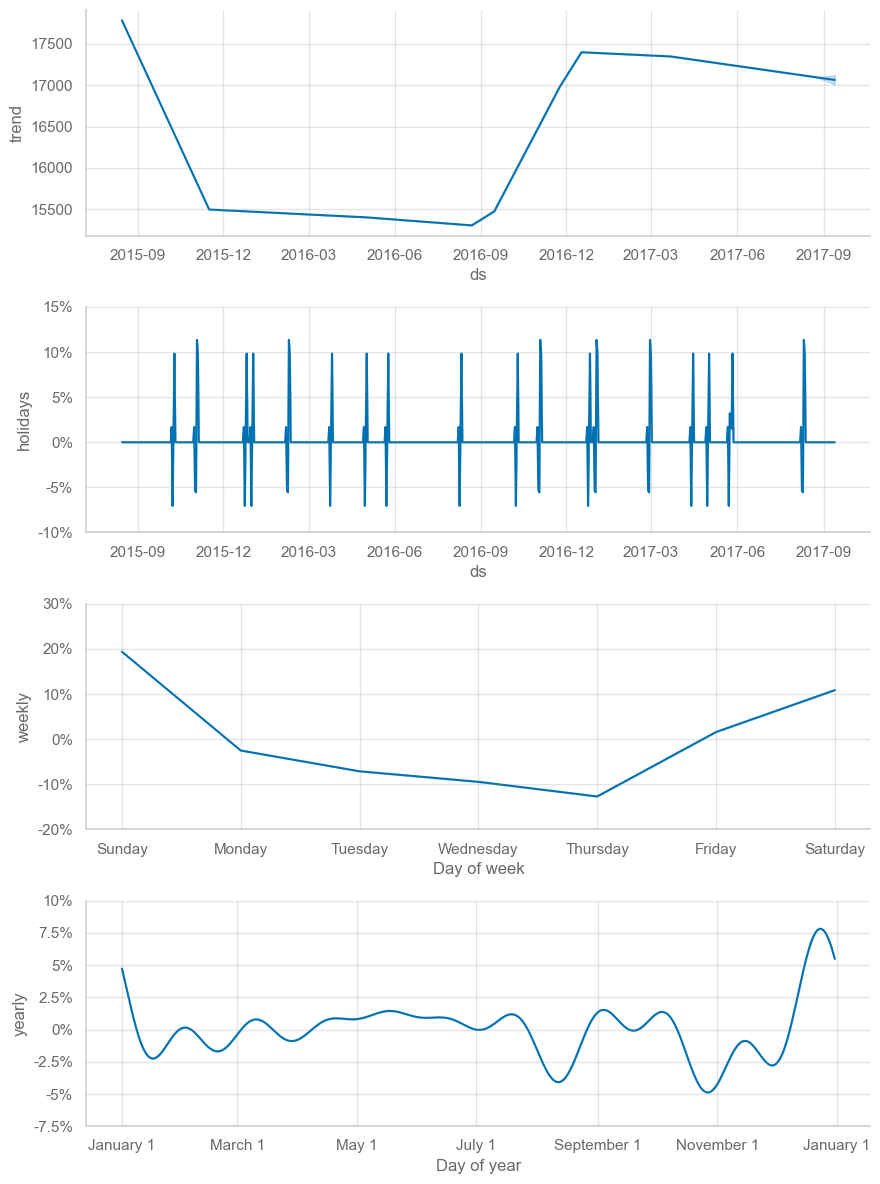

In [58]:
#Prophet model
forecasted_dfs = []

#visualize only first 5 features
for feature in total_sales_df.columns[:5]:

    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']

    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
    df_copy['ds'] = pd.to_datetime(df_copy['ds'])

    df_copy_= df_copy[df_copy['ds'] < forecast_start_date]

    #finding right param dict for this category
    params_dict = dicts[feature]

    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode= 'multiplicative',
                holidays = holiday                                          
                )
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods= prediction_days)
    fcst_prophet_train = m.predict(future)

    #plotting Prophet time series forecast
    fig1= m.plot(fcst_prophet_train)
    plt.suptitle(feature)
    fig2 = m.plot_components(fcst_prophet_train)

    #add only forecasted data into predicted_df
    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    forecasted_dfs.append(forecasted_df)

    
   

